In [11]:
import pandas as pd
import os
import mne
import numpy as np
import scipy
import matplotlib.pyplot as plt


filename_template =  "data/ds004504/{}/eeg/{}_task-eyesclosed_eeg.set"
# 1-36 have Alzheimers, 37-65 have frontotemporal dementia, 66-88 are healthy
ALZ_R = 36
FTD_R = 65
HEA_R = 88

H = 0
A = 1
F = 2

In [13]:
def read_raw_eeg(file,sampling_rate=128,n_channels=19):
    '''Returns Ex19 spectrograms'''
    
    # Load data (19xS where S = number of samples)
    data = mne.io.read_raw_eeglab(file, preload=True) 
    data.set_eeg_reference() # Ensures the values are referenced around the average wave
    
    # Downsample to 128hz for storage purposes. (19xS')
    # Frequencies <= 45hz (45hz from preprocessing done by dataset) should be preserved since 45<= 128/2 (Nyquist Theorem)
    data.resample(sampling_rate)
    
    # Epoch data into 2 second time slices (Ex19xS" where E is number of epochs)
    events = mne.make_fixed_length_events(data, duration=2.0, overlap=1.0)
    epochs = mne.Epochs(data, events, tmin=0, tmax=2.0, baseline=None, preload=True)
    X_epochs = epochs.get_data()  # shape: (n_epochs, n_channels, n_samples)
    n_epochs, n_channels, n_samples = X_epochs.shape
    
    # Create Ex19 spectrograms (Ex19xFxT where F is number of freq bins and T is number of T bins)   
    data_points = []
    for epoch in range(n_epochs):
        epoch_ls = []

        # 64 = half a second per window, 32 = overlap of half a window
        for ch in range(n_channels):
            f, t, Sxx = scipy.signal.spectrogram(X_epochs[epoch, ch, :], 
                                                 fs=sampling_rate,
                                                 nperseg=64,
                                                 noverlap=32)
            epoch_ls.append(Sxx) 
        epoch_spec = np.stack(epoch_ls, axis=0)
        data_points.append(epoch_spec)
    data_points = np.stack(data_points, axis=0)
    return data_points

In [14]:
np.full(23, 5)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5])

In [15]:
def create_data():
    mne.set_log_level("WARNING")
    for sub in sorted([i for i in os.listdir("data/ds004504/derivatives")]):
        if "sub" not in sub:
            continue
        num = int("".join([j for j in filter(str.isdigit, sub)]))

        X = read_raw_eeg(filename_template.format(sub, sub))
        e = X.shape[0]

        label = -1
        if num <= ALZ_R:
            label = A
        elif num <= FTD_R:
            label = F
        else:
            label = H
        
        y = np.full(e, label)


        #Last variable means 1 second half window
        np.save(f"data/noisy_spectrogram_data/{sub}_X_noisy.npy", X)
        np.save(f"data/noisy_spectrogram_data/{sub}_y_noisy.npy", y)
        print(f"Saved {sub} data")
    mne.set_log_level("INFO")

create_data()
    

Saved sub-001 data
Saved sub-002 data
Saved sub-003 data
Saved sub-004 data
Saved sub-005 data
Saved sub-006 data
Saved sub-007 data
Saved sub-008 data
Saved sub-009 data
Saved sub-010 data
Saved sub-011 data
Saved sub-012 data
Saved sub-013 data
Saved sub-014 data
Saved sub-015 data
Saved sub-016 data
Saved sub-017 data
Saved sub-018 data
Saved sub-019 data
Saved sub-020 data
Saved sub-021 data
Saved sub-022 data
Saved sub-023 data
Saved sub-024 data
Saved sub-025 data
Saved sub-026 data
Saved sub-027 data
Saved sub-028 data
Saved sub-029 data
Saved sub-030 data
Saved sub-031 data
Saved sub-032 data
Saved sub-033 data
Saved sub-034 data
Saved sub-035 data
Saved sub-036 data
Saved sub-037 data
Saved sub-038 data
Saved sub-039 data
Saved sub-040 data
Saved sub-041 data
Saved sub-042 data
Saved sub-043 data
Saved sub-044 data
Saved sub-045 data
Saved sub-046 data
Saved sub-047 data
Saved sub-048 data
Saved sub-049 data
Saved sub-050 data
Saved sub-051 data
Saved sub-052 data
Saved sub-05

In [5]:
read_raw_eeg("data/ds004504/derivatives/sub-001/eeg/sub-001_task-eyesclosed_eeg.set").shape

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
598 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 598 events and 257 original time points ...
0 bad epochs dropped


(598, 19, 65, 3)

In [44]:
X = np.load("/Users/josephthi/Desktop/UCI_Classes/cs184A/CS_184A_Final Project/spectrogram_data/sub-001_X.npy")
Y = np.load("/Users/josephthi/Desktop/UCI_Classes/cs184A/CS_184A_Final Project/spectrogram_data/sub-001_y.npy")

In [46]:
print(X.shape)
print(Y.shape)

(598, 19, 33, 7)
(598,)


In [51]:
sample_idx = 1
channel_idx = 0
spec = X[sample_idx, channel_idx]

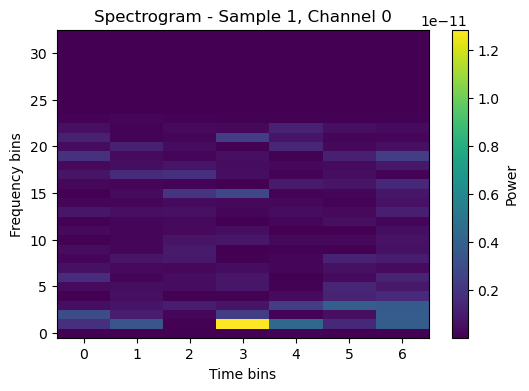

In [52]:
plt.figure(figsize=(6, 4))
plt.imshow(spec, aspect='auto', origin='lower')
plt.colorbar(label='Power')
plt.xlabel("Time bins")
plt.ylabel("Frequency bins")
plt.title(f"Spectrogram - Sample {sample_idx}, Channel {channel_idx}")
plt.show()